# Summary statistics for the French Wikipedia

In this notebook we generate some simple summarizing statistics for the French Wikipedia, using data collected from the analysis scripts.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datetime import date, datetime
from dateutil.rrule import rrule, MONTHLY
from matplotlib.dates import epoch2num, DateFormatter, YearLocator
from interank.wikidata import WikiData

%matplotlib inline

## Loading the dataset

In [2]:
dataset = WikiData("/data/datasets/frwiki")

articles = dataset.get_articles()
users = dataset.get_users()
edits = dataset.get_raw_combined_data()

We can separate the edits contributed by registered accounts, anonymous users and bots.

In [3]:
# Maps Wikipedia IDs to user name.
wuid2name = {user[0]: user[1] for user in users.values()}

In [4]:
def is_bot(wuid):
    # C.f. Wikipedia bot policy:
    # <https://en.wikipedia.org/wiki/Wikipedia:Bot_policy>
    name = wuid2name.get(wuid, "")  # Sometimes the lookup fails...
    return name[-3:].lower() == "bot"

def is_registered(wuid):
    return wuid[0] == "r"

edits_bot = list(filter(lambda x: is_bot(x[3]), zip(*edits)))
edits_reg = list(filter(lambda x: is_registered(x[3]) and not is_bot(x[3]), zip(*edits)))
edits_unreg = list(filter(lambda x: not is_registered(x[3]), zip(*edits)))

## Statistics related to the articles

In [5]:
n_edits = np.array(list(a[2] for a in articles.values()))
n_editors = np.array(list(a[3] for a in articles.values()))

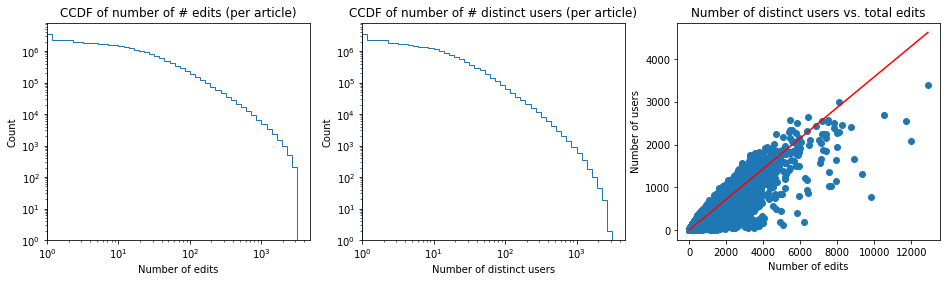

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))

ax1.hist(n_edits, bins=np.logspace(0, 3.5, num=50), cumulative=-1, log=True, histtype="step")
ax1.set_xscale("log")
ax1.set_xlim(xmin=1.0)
ax1.set_ylim(ymin=1.0)
ax1.set_xlabel("Number of edits")
ax1.set_ylabel("Count")
ax1.set_title("CCDF of number of # edits (per article)")

ax2.hist(n_editors, bins=np.logspace(0, 3.5, num=50), cumulative=-1, log=True, histtype="step")
ax2.set_xscale("log")
ax2.set_xlim(xmin=1.0)
ax2.set_ylim(ymin=1.0)
ax2.set_xlabel("Number of distinct users")
ax2.set_ylabel("Count")
ax2.set_title("CCDF of number of # distinct users (per article)")

ax3.scatter(n_edits, n_editors)
m, b = np.polyfit(n_edits, n_editors, deg=1)
xs = np.linspace(min(n_edits), max(n_edits), num=50)
ax3.plot(xs, m * xs + b, "r-")
ax3.set_ylabel("Number of users")
ax3.set_xlabel("Number of edits")
ax3.set_title("Number of distinct users vs. total edits")

## Statistics related to the users

In [7]:
n_edits = np.array(list(a[4] for a in users.values()))
n_articles = np.array(list(a[5] for a in users.values()))

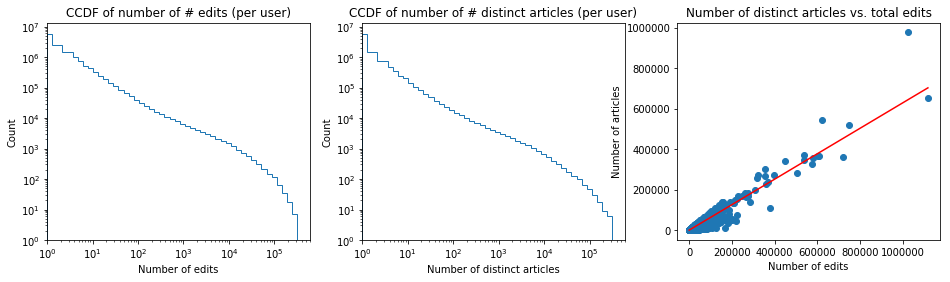

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))

ax1.hist(n_edits, bins=np.logspace(0, 5.5, num=50), cumulative=-1, log=True, histtype="step")
ax1.set_xscale("log")
ax1.set_xlim(xmin=1.0)
ax1.set_ylim(ymin=1.0)
ax1.set_xlabel("Number of edits")
ax1.set_ylabel("Count")
ax1.set_title("CCDF of number of # edits (per user)")

ax2.hist(n_articles, bins=np.logspace(0, 5.5, num=50), cumulative=-1, log=True, histtype="step")
ax2.set_xscale("log")
ax2.set_xlim(xmin=1.0)
ax2.set_ylim(ymin=1.0)
ax2.set_xlabel("Number of distinct articles")
ax2.set_ylabel("Count")
ax2.set_title("CCDF of number of # distinct articles (per user)")

ax3.scatter(n_edits, n_articles)
m, b = np.polyfit(n_edits, n_articles, deg=1)
xs = np.linspace(min(n_edits), max(n_edits), num=50)
ax3.plot(xs, m * xs + b, "r-")
ax3.set_xlabel("Number of edits")
ax3.set_ylabel("Number of articles")
ax3.set_title("Number of distinct articles vs. total edits")

We can also get a sense of how contributions are distributed among users by plotting the number of edits per user.

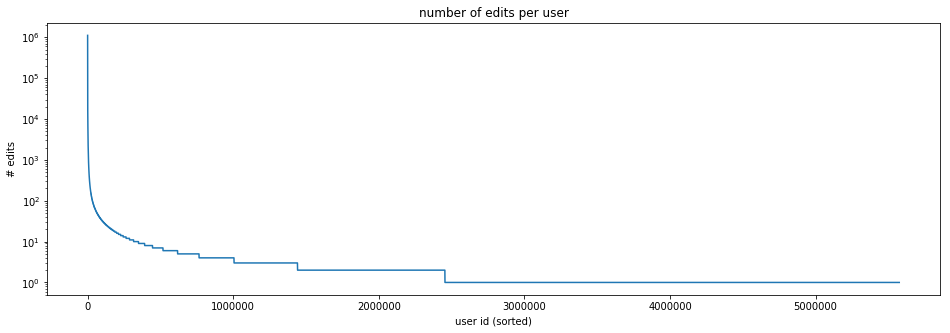

In [9]:
idx = np.argsort(n_edits)[::-1]

fig, ax = plt.subplots(figsize=(16, 5))
ax.semilogy(n_edits[idx])
ax.set_title("number of edits per user")
ax.set_xlabel("user id (sorted)")
ax.set_ylabel("# edits")

In [10]:
n_users = len(idx)
frac = 0.01
print("{:.2f} % of edits made by top {} fraction of users".format(
        100 * n_edits[idx[:int(n_users * frac)]].sum() / n_edits.sum(), frac))

83.22 % of edits made by top 0.01 fraction of users


##  Distribution of edits over time

In [11]:
dt = datetime.fromtimestamp(min(edits[1]))
start = date(dt.year, dt.month, 1)

dt = datetime.fromtimestamp(max(edits[1]))
end = date(dt.year, dt.month, 28)

bins = epoch2num([dt.timestamp() for dt in rrule(MONTHLY, dtstart=start, until=end)])

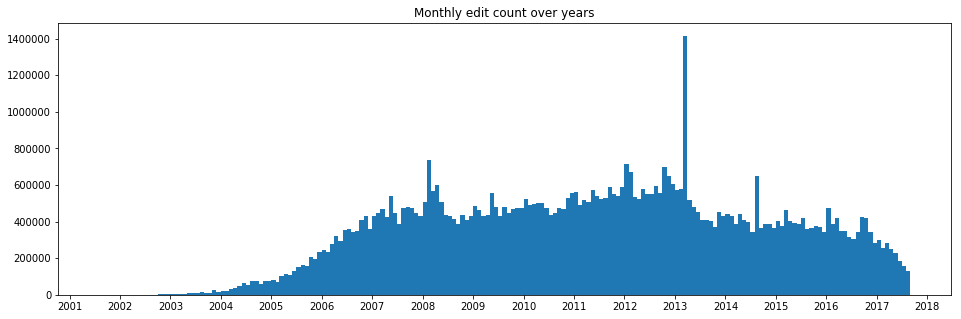

In [12]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.hist(epoch2num(edits[1]), bins=bins)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.set_title("Monthly edit count over years")

We can also analyse the number of edits performed by bots, registered users and anonymous users separately. The surge in edits around 2013 can be mostly attributed to bots, as seen below.

In [13]:
ts_bot = epoch2num([edit[1] for edit in edits_bot])
ts_reg = epoch2num([edit[1] for edit in edits_reg])
ts_unreg = epoch2num([edit[1] for edit in edits_unreg])

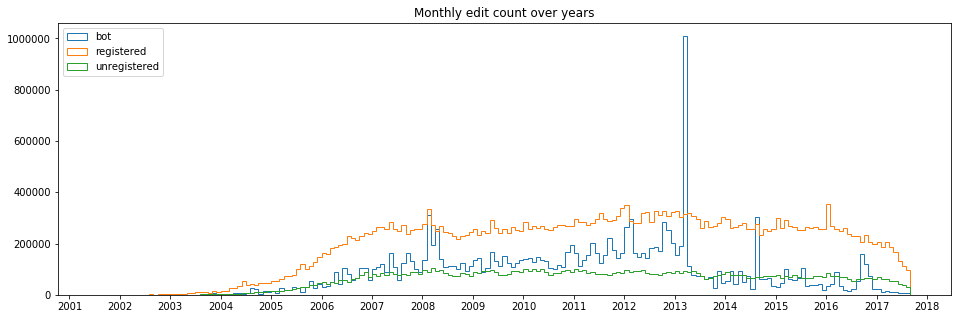

In [14]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.hist(ts_bot, bins=bins, histtype="step", label="bot")
ax.hist(ts_reg, bins=bins, histtype="step", label="registered")
ax.hist(ts_unreg, bins=bins, histtype="step", label="unregistered")
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.set_title("Monthly edit count over years")
ax.legend(loc="upper left")

It seems that edits by registered users seem to have more or less stabilized around 2010, most fluctuations can be attributed to edits by bot accounts.

## Analyzing edit content

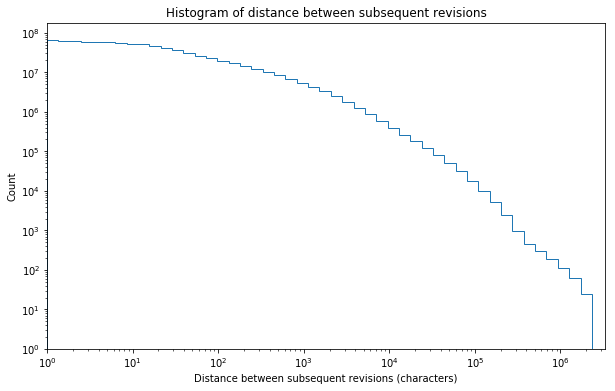

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(edits[5], bins=np.logspace(0,6.5, num=50), log=True, cumulative=-1, histtype="step")
ax.set_xlim(xmin=1.0)
ax.set_ylim(ymin=1.0)
ax.set_xscale("log")
ax.set_xlabel("Distance between subsequent revisions (characters)")
ax.set_ylabel("Count")
ax.set_title("Histogram of distance between subsequent revisions")

## Training set / test set split

In [17]:
train_data = dataset.get_train_data()
test_data = dataset.get_test_data()

print("=== # edits")
print("Training set: {: >10,}".format(len(train_data[0])))
print("Test set:     {: >10,}".format(len(test_data[0])))

=== # edits
Training set: 57,984,080
Test set:      4,512,971


In [18]:
usrs_train = set(train_data[0])
arts_train = set(train_data[1])
usrs_test = set(test_data[0])
arts_test = set(test_data[1])

In [19]:
print("=== combined dataset")
print("# distinct users:            {: >8,}".format(len(usrs_train | usrs_test)))
print("  ... in test set:           {: >8,}".format(len(usrs_test)))
print("  ... *not* in training set: {: >8,}".format(len(usrs_test - usrs_train)))
print("# distinct articles:         {: >8,}".format(len(arts_train | arts_test)))
print("  ... in test set:           {: >8,}".format(len(arts_test)))
print("  ... *not* in training set: {: >8,}".format(len(arts_test - arts_train)))

=== combined dataset
# distinct users:            5,303,908
  ... in test set:            527,451
  ... *not* in training set:  438,434
# distinct articles:         1,895,810
  ... in test set:            730,506
  ... *not* in training set:  122,135


In [20]:
cnt = 0
for uid in test_data[0]:
    if uid in usrs_train:
        cnt += 1
print("% edits in test set with unknown user:    {:.1f} %".format(100 * (1 - cnt / len(test_data[0]))))

cnt = 0
for aid in test_data[1]:
    if aid in arts_train:
        cnt += 1
print("% edits in test set with unknown article: {:.1f} %".format(100 * (1 - cnt / len(test_data[0]))))

% edits in test set with unknown user:    21.7 %
% edits in test set with unknown article: 16.6 %
